In [1]:
import os
os.chdir('..')

In [2]:
import json
import numpy as np
import torch
from tqdm.auto import tqdm
from PIL import Image
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
from IPython.display import display
import torch.nn.functional as F

from modeling import get_model
from diffusion.scheduler import get_scheduler
from diffusion.sampler import get_sampler
from utils import count_parameters

In [3]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [4]:
def tensor2image(tensor, value_range=None, resize_factor=None):
    if value_range is not None:
        tensor = (tensor - value_range[0]) / (value_range[1] - value_range[0])
    tensor = tensor.clamp(0, 1)
    image = to_pil_image(tensor)
    if resize_factor is not None:
        new_size = (int(image.width * resize_factor), int(image.height * resize_factor))
        image = image.resize(new_size, resample=Image.NEAREST)
    return image

In [5]:
def load_ckpt(ckpt_dir, ckpt_name, ema=True, device='cpu'):
    with open(os.path.join(ckpt_dir, 'train_args.json'), 'r') as f:
        train_args = json.load(f)

    model = get_model(train_args['model_type'], **train_args['model_cfg'])
    ckpt_path = os.path.join(
        ckpt_dir, 'ckpts', ckpt_name, 
        'ema_model.pt' if ema else 'model.pt'
    )
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device)

    scheduler = get_scheduler(train_args['scheduler_type'], **train_args['scheduler_cfg'])
    sampler = get_sampler(train_args['sampler_type'], **train_args['sampler_cfg'])

    return model, scheduler, sampler, train_args['dataset']

In [6]:
def interpolate(z1, z2, alpha: float, method='spherical'):
    if method == 'linear':
        return (1 - alpha) * z1 + alpha * z2
    elif method == 'spherical':
        orig_shape = z1.shape
        z1, z2 = z1.view(-1), z2.view(-1)
        cos = F.cosine_similarity(z1, z2, dim=-1)
        theta = torch.acos(cos)
        w1 = torch.sin((1.0 - alpha) * theta) / torch.sin(theta)
        w2 = torch.sin(alpha * theta) / torch.sin(theta)
        # print(f'alpha: {alpha:.2f}, theta: {theta.item():.4f}, w1: {w1.item():.4f}, w2: {w2.item():.4f}')
        ret = w1 * z1 + w2 * z2
        return ret.view(orig_shape)
    elif method == 'variance_preserving':
        return np.sqrt(1 - alpha) * z1 + np.sqrt(alpha) * z2
    else:
        raise ValueError(f"Unknown interpolation method: {method}")

In [7]:
def slerp_1d(z1: torch.Tensor, z2: torch.Tensor, alphas: list[float], dot_tol=0.9999) -> torch.Tensor:
    v0 = z1.flatten()
    v1 = z2.flatten()
    dot = F.cosine_similarity(v0, v1, dim=0)
    
    results = []
    if dot > dot_tol:
        for a in alphas:
            res = (1.0 - a) * z1 + a * z2
            results.append(res)
        return torch.stack(results)
    omega = torch.acos(torch.clamp(dot, -1.0, 1.0))
    sin_omega = torch.sin(omega)
    
    for a in alphas:
        weight0 = torch.sin((1.0 - a) * omega) / sin_omega
        weight1 = torch.sin(a * omega) / sin_omega
        res = weight0 * z1 + weight1 * z2
        results.append(res)
        
    return torch.stack(results)

In [8]:
def slerp_2d(
        z00: torch.Tensor, z10: torch.Tensor, 
        z01: torch.Tensor, z11: torch.Tensor, 
        alphas_x: list[float], alphas_y: list[float]
) -> torch.Tensor:
    """
    z00 (Top-Left)     --- alphas_x --->  z10 (Top-Right)
      |                                     |
    alphas_y                              alphas_y
      |                                     |
    z01 (Bottom-Left)  --- alphas_x --->  z11 (Bottom-Right)
    
    Returns:
        (len(alphas_y), len(alphas_x), C, H, W)
    """

    z_top_list = slerp_1d(z00, z10, alphas_x)
    z_bottom_list = slerp_1d(z01, z11, alphas_x)
    
    grid = []
    for alpha_y in alphas_y:
        row = []
        for x_idx in range(len(alphas_x)):
            interpolated_z = slerp_1d(
                z_top_list[x_idx], 
                z_bottom_list[x_idx], 
                [alpha_y]
            )[0]
            row.append(interpolated_z)
        grid.append(torch.stack(row))
    grid = torch.stack(grid)  # (len(alphas_y), len(alphas_x), C, H, W)
    return grid

In [9]:
sampling_steps = 100
model, scheduler, sampler, dataset_type = load_ckpt('outputs/beta_mnist_base', 'ckpt-080000')
# model, scheduler, sampler, dataset_type = load_ckpt('outputs/beta_cifar10_base', 'ckpt-180000')
sampler.set_steps(sampling_steps)
model.eval()
model.to(device)
pred_fn = model.get_pred_fn()
count_parameters(model)

13717633

In [10]:
image_save_dir = 'resources/ppt_image'
os.makedirs(image_save_dir, exist_ok=True)

seed: 124816


  0%|          | 0/100 [00:00<?, ?it/s]

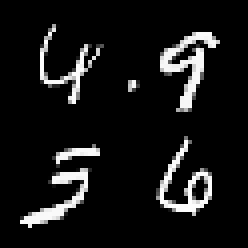

In [11]:
# seed = torch.randint(0, 1000000, (1,)).item()
seed = 124816
print(f'seed: {seed}')
if dataset_type == 'mnist':
    image_shape = (1, 28, 28)
elif dataset_type == 'cifar10':
    image_shape = (3, 32, 32)
else:
    raise ValueError(f"Unknown dataset type: {dataset_type}")
gen = torch.Generator().manual_seed(seed)
z1 = torch.randn(image_shape, generator=gen)
z2 = torch.randn(image_shape, generator=gen)
z3 = torch.randn(image_shape, generator=gen)
z4 = torch.randn(image_shape, generator=gen)
sample = sampler.sample(torch.stack([z1, z2, z3, z4]).to(device), scheduler, pred_fn).cpu()
img = tensor2image(make_grid(sample, nrow=2), resize_factor=4)
display(img)
# img.save(os.path.join(image_save_dir, f'interpolate_corner_{seed}.png'))

torch.Size([9, 1, 28, 28])


  0%|          | 0/100 [00:00<?, ?it/s]

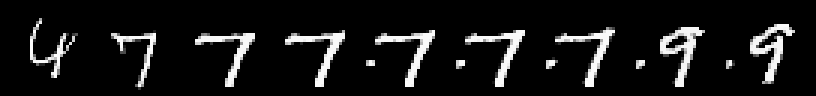

In [12]:
inter_steps = 9
alphas = torch.linspace(0, 1, steps=inter_steps)
inter_sp = slerp_1d(z1, z2, alphas)
print(inter_sp.shape)
sp = sampler.sample(inter_sp.to(device), scheduler, pred_fn).cpu()
img = tensor2image(make_grid(sp, nrow=inter_steps), resize_factor=3)
display(img)
img.save(os.path.join(image_save_dir, f'{dataset_type}_interpolate_1d_{seed}.png'))

torch.Size([9, 9, 1, 28, 28])


  0%|          | 0/100 [00:00<?, ?it/s]

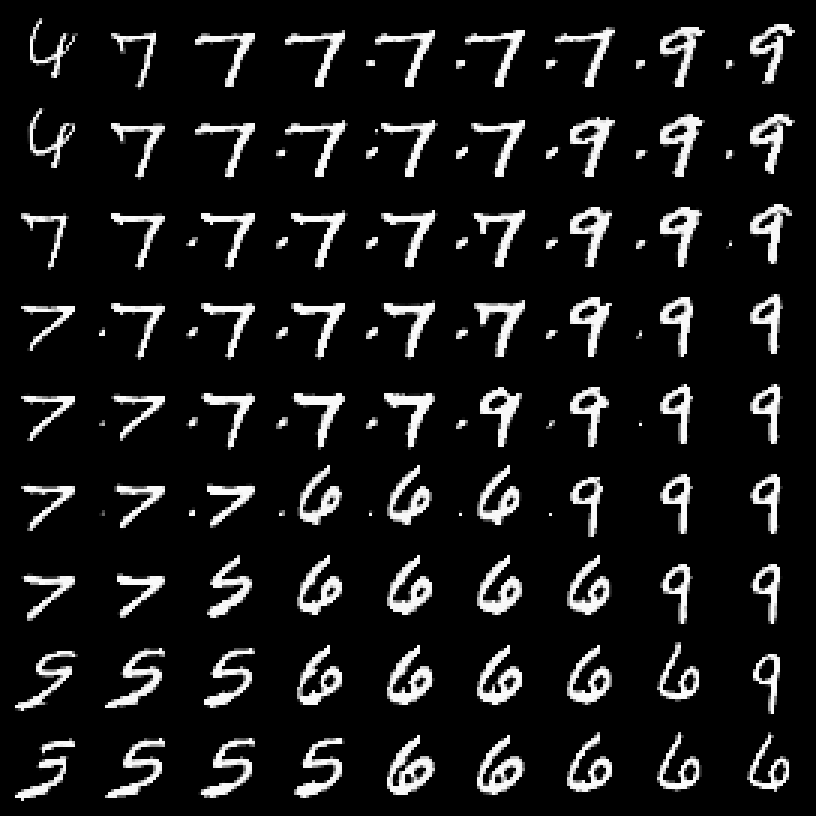

In [13]:
inter2d = slerp_2d(z1, z2, z3, z4, alphas_x=alphas, alphas_y=alphas)
print(inter2d.shape)
inter2d = inter2d.view(-1, *image_shape)  # (inter_steps * inter_steps, C, H, W)
ret = sampler.sample(inter2d.to(device), scheduler, pred_fn).cpu()
img = tensor2image(make_grid(ret, nrow=inter_steps), resize_factor=3)
display(img)
img.save(os.path.join(image_save_dir, f'interpolate_2d_{seed}.png'))

In [14]:
from diffusion.sampler import BaseSampler

class CustomDDIMSampler(BaseSampler):
    def __init__(self, n_steps, clip_latent=True, pbar=False, pbar_kwargs=None):
        super().__init__(n_steps, pbar, pbar_kwargs)
        self.clip_latent = clip_latent
    
    @torch.no_grad()
    def sample(
            self, 
            z: torch.Tensor, scheduler, pred_fn, 
            initial_timestep=None
    ):

        t_steps = torch.linspace(
            scheduler.n_steps - 1, 0,
            steps=self.n_steps + 1,
            dtype=torch.int64,
            device=z.device
        )[:-1]
        if initial_timestep is not None:
            assert (t_steps == initial_timestep).any().item(), "initial_timestep must be in t_steps"
            idx = (t_steps == initial_timestep).nonzero(as_tuple=True)[0].item()
            t_steps = t_steps[idx:]

        iterator = self.prepare_iterator(range(len(t_steps)))
        for i in iterator:
            eps_pred = pred_fn(z, t_steps[i].repeat(z.size(0)))
            t = scheduler.get_schedule(t_steps[i])

            alpha_t_ = torch.sqrt(t.alpha_sq).to(z.dtype)
            sigma_t_ = torch.sqrt(t.sigma_sq).to(z.dtype)
            x0_pred = (z - sigma_t_ * eps_pred) / alpha_t_
            if self.clip_latent:
                x0_pred = torch.clip(x0_pred, -1, 1)

            if i < len(t_steps) - 1:
                t_prime = scheduler.get_schedule(t_steps[i + 1])

                alpha_t_prime_ = torch.sqrt(t_prime.alpha_sq).to(z.dtype)
                sigma_t_prime_ = torch.sqrt(t_prime.sigma_sq).to(z.dtype)
                z = alpha_t_prime_ * x0_pred + sigma_t_prime_ * eps_pred

            else:
                z = x0_pred

        return z

In [15]:
sampler = CustomDDIMSampler(n_steps=100)

In [16]:
from torchvision.datasets import MNIST, CIFAR10
import torchvision.transforms as T
import torchvision.transforms.functional as TF

ds_class = MNIST if dataset_type == 'mnist' else CIFAR10
transform = T.Compose([T.ToTensor(), T.Normalize(0.5, 0.5)])
ds = ds_class('~/datasets', download=True, transform=transform)
ds

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/jimyeong/datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

Label: 7


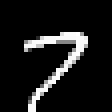

In [17]:
sample_idx = 123
sample_x, sample_y = ds[sample_idx]
print(f"Label: {sample_y}")
tensor2image(sample_x, resize_factor=4)

In [18]:
noise = torch.randn_like(sample_x)
n_perturb_steps = 10
perturb_steps = torch.linspace(0, scheduler.n_steps-1, steps=n_perturb_steps+1, dtype=torch.int64)[1:]
perturb_steps

tensor([ 99, 199, 299, 399, 499, 599, 699, 799, 899, 999])

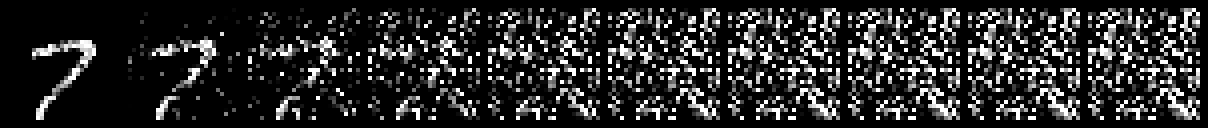

In [19]:
perturbed = sample_x.unsqueeze(0).repeat_interleave(n_perturb_steps, dim=0)
perturbed = scheduler.diffuse(perturbed, perturb_steps, noise)
tensor2image(make_grid(perturbed.cpu(), nrow=n_perturb_steps), resize_factor=4)

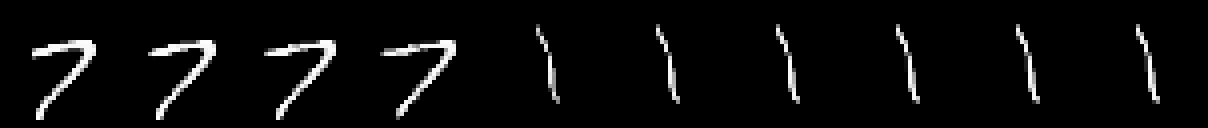

In [20]:
target_cls = 1
pred_fn = model.get_pred_fn(cond=torch.tensor([target_cls], device=device))
rets = []
for i, step in enumerate(perturb_steps):
    perturbed_x = perturbed[i].unsqueeze(0).to(device)
    ret = sampler.sample(perturbed_x, scheduler, pred_fn, initial_timestep=step)
    rets.append(ret[0].cpu())
img = tensor2image(make_grid(rets, nrow=n_perturb_steps), resize_factor=4)
display(img)

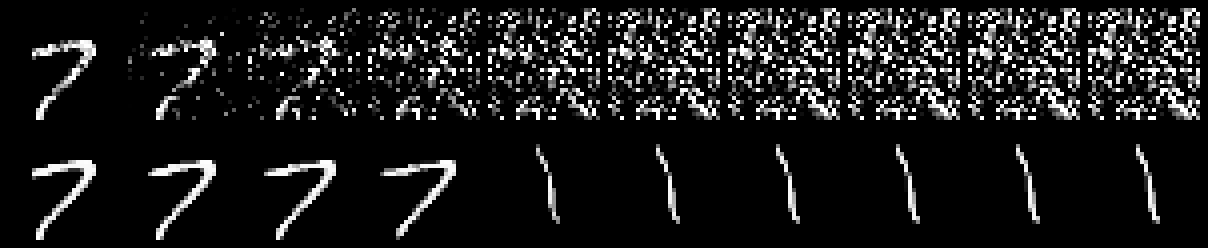

In [21]:
tmp = torch.cat([perturbed, torch.stack(rets, dim=0)], dim=0)
img = tensor2image(make_grid(tmp, nrow=n_perturb_steps), resize_factor=4)
display(img)
img.save(os.path.join(image_save_dir, f'{dataset_type}_perturbation_{sample_idx}_to_{target_cls}.png'))

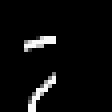

In [22]:
mask_left = torch.zeros_like(sample_x)
mask_left[:, :, :sample_x.shape[2]//2] = 1
mask_right = 1 - mask_left
perturbed_left = sample_x * mask_left
perturbed_right = sample_x * mask_right
tensor2image(perturbed_left, resize_factor=4)

In [31]:
from diffusion.sampler import BaseSampler

class RepaintSampler(BaseSampler):
    def __init__(self, n_steps, clip_latent=True, pbar=False, pbar_kwargs=None):
        super().__init__(n_steps, pbar, pbar_kwargs)
        self.clip_latent = clip_latent
    
    @torch.no_grad()
    def sample(
            self, 
            z: torch.Tensor, scheduler, pred_fn, 
            x, mask
    ):
        # mask - 1 for unknown, 0 for known

        t_steps = torch.linspace(
            scheduler.n_steps - 1, 0,
            steps=self.n_steps + 1,
            dtype=torch.int64,
            device=z.device
        )[:-1]

        noise = z.clone()

        iterator = self.prepare_iterator(range(len(t_steps)))
        for i in iterator:


            eps_pred = pred_fn(z, t_steps[i].repeat(z.size(0)))
            t = scheduler.get_schedule(t_steps[i])

            alpha_t_ = torch.sqrt(t.alpha_sq).to(z.dtype)
            sigma_t_ = torch.sqrt(t.sigma_sq).to(z.dtype)
            x0_pred = (z - sigma_t_ * eps_pred) / alpha_t_
            if self.clip_latent:
                x0_pred = torch.clip(x0_pred, -1, 1)

            if i < len(t_steps) - 1:
                t_prime = scheduler.get_schedule(t_steps[i + 1])

                alpha_t_prime_ = torch.sqrt(t_prime.alpha_sq).to(z.dtype)
                sigma_t_prime_ = torch.sqrt(t_prime.sigma_sq).to(z.dtype)
                z = alpha_t_prime_ * x0_pred + sigma_t_prime_ * eps_pred
                known_part = scheduler.diffuse(x, t_steps[i].repeat(z.size(0)), noise)

            else:
                z = x0_pred
                known_part = x
            
            unknwon_part = z

            # merge known and unknown part using mask
            z = known_part * (1 - mask) + unknwon_part * mask
            # if i % 10 == 0:
            #     print(f"Step {i}/{len(t_steps)}, timestep: {t_steps[i].item()}")
            #     display(tensor2image(make_grid(z.cpu(), nrow=1), resize_factor=4))
            

        return z

Label: 3


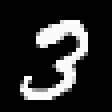

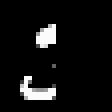

In [51]:
sample_idx = 12345
sample_x, sample_y = ds[sample_idx]
print(f"Label: {sample_y}")
img = tensor2image(sample_x, resize_factor=4)
img.save(os.path.join(image_save_dir, f'{dataset_type}_repaint_input_{sample_idx}.png'))
display(img)
img = tensor2image(sample_x * mask_left, resize_factor=4)
img.save(os.path.join(image_save_dir, f'{dataset_type}_repaint_input_masked_{sample_idx}.png'))
display(img)

  0%|          | 0/10 [00:00<?, ?it/s]

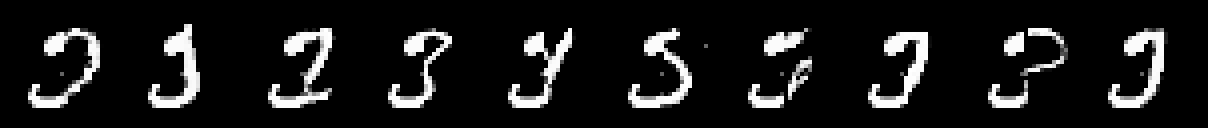

In [52]:
rep_sampler = RepaintSampler(n_steps=100)
samples = []
for target_cls in tqdm(range(10)):
# target_cls = 2

    xx = sample_x.unsqueeze(0).to(device)
    mask = mask_right.unsqueeze(0).to(device)
    eps = torch.randn_like(xx)
    pred_fn = model.get_pred_fn(cond=torch.tensor([target_cls], device=device))
    sampled = rep_sampler.sample(eps, scheduler, pred_fn, xx, mask)
    # tensor2image(sampled[0].cpu(), resize_factor=4)
    samples.append(sampled[0].cpu())
img = tensor2image(make_grid(samples, nrow=10), resize_factor=4)
display(img)
img.save(os.path.join(image_save_dir, f'{dataset_type}_repaint_{sample_idx}.png'))

Generating samples with guidance scale -1.0
Generating samples with guidance scale 0
Generating samples with guidance scale 0.5
Generating samples with guidance scale 1.0
Generating samples with guidance scale 1.5
Generating samples with guidance scale 2.0


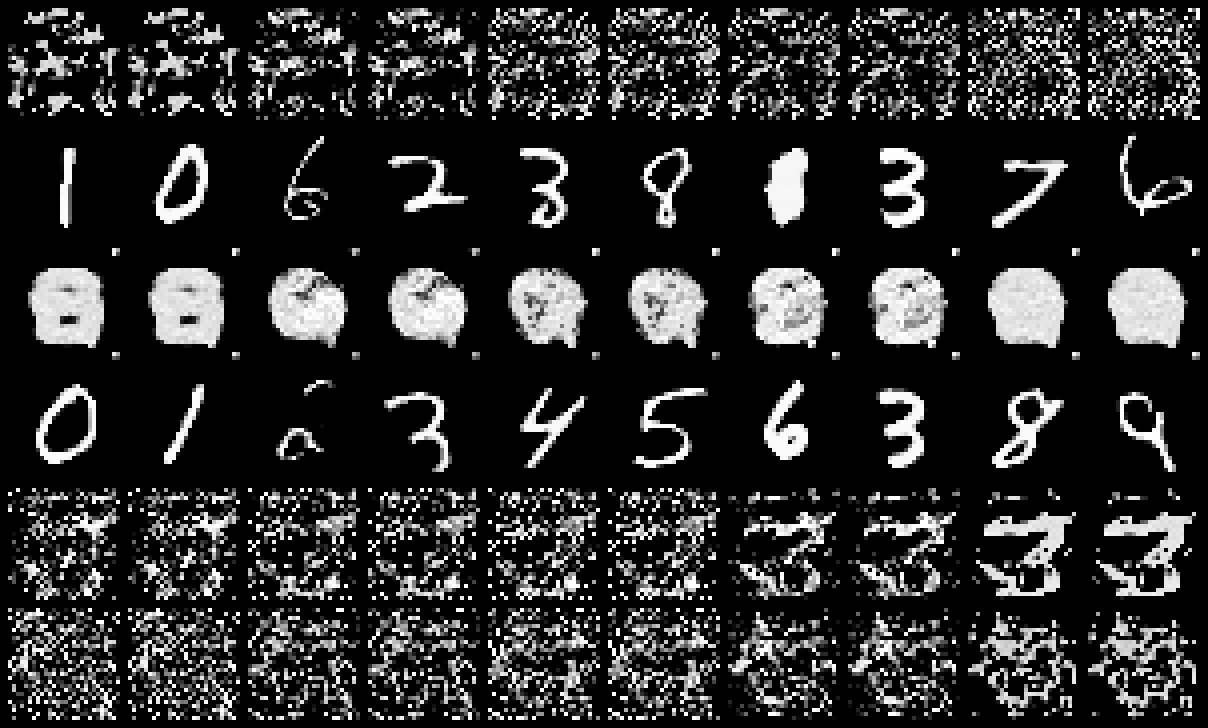

In [57]:
n_samples = 10
seed = 2351
gen = torch.Generator().manual_seed(seed)
z = torch.randn((n_samples, *image_shape), generator=gen)
cond = torch.arange(n_samples) % 10
cond = cond.to(device)
z = z.to(device)

guidance_scales = [-1.0, 0, 0.5, 1.0, 1.5, 2.0]

ret = []
for w in guidance_scales:
    print(f"Generating samples with guidance scale {w}")
    pred_fn = model.get_pred_fn(cond=cond, guidance_scale=w)
    sampled = sampler.sample(z, scheduler, pred_fn)
    ret.append(sampled.cpu())
ret = torch.cat(ret, dim=0)
img = tensor2image(make_grid(ret, nrow=n_samples), resize_factor=4)
display(img)
img.save(os.path.join(image_save_dir, f'{dataset_type}_guidance_scale_{seed}.png'))